<a href="https://colab.research.google.com/github/petergchang/sarkka-jax/blob/main/Ch5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#5. Extended and Unscented Kalman Filtering

This notebook replicates the figures of Chapter 5 of Särkkä's "Bayesian Filtering and Smoothing" using JAX.

Simo Särkkä (2013), “Bayesian Filtering and Smoothing,” Cambridge University Press. Available: https://users.aalto.fi/~ssarkka/pub/cup_book_online_20131111.pdf

This JAX translation is by Peter G. Chang ([@petergchang](https://github.com/petergchang))



## 5.0 Imports

In [1]:
%matplotlib inline

import jax
import jax.numpy as jnp
import jax.random as jr
from jax import lax
import matplotlib.pyplot as plt

## 5.2 Extended Kalman Filter

First, we simulate the pendulum data using the following transition model:
\begin{align*}
  \begin{pmatrix} x_{1,k} \\ x_{2,k} \end{pmatrix} &= 
  \begin{pmatrix} x_{1,k-1} + x_{2,k-1} \Delta t \\
    x_{2,k-1} - g \sin(x_{1,k-1}) \Delta t
  \end{pmatrix} + q_{k-1} \\
  y_{k} &= \sin(x_{1,k}) + r_k \\
  y_{x_k} &= \arcsin(y_k) = \arcsin(\sin(x_{1,k}) + r_k)
\end{align*}

In [7]:
# Function to simulate pendulum
def simulate_pendulum(key, m_0, f, Q, h, r, steps):
    def _step(carry, rng):
        state = carry
        rng1, rng2 = jr.split(rng, 2)
        next_state = f(state) + jr.multivariate_normal(rng1, jnp.zeros(M), Q)
        obs = h(next_state) + jr.normal(rng2) * r
        return next_state, (next_state, obs)

    M = m_0.shape[-1]
    state = m_0
    rngs = jr.split(key, steps)
    _, (states, observations) = lax.scan(
        _step, state, rngs
    )
    return states, observations

In [8]:
# Params for pendulum simulation
key = jr.PRNGKey(0)
m_0 = jnp.array([1.5, 0])
dt = 0.0125
q = 1
g = 9.8
Q = jnp.array([[q*dt**3/3, q*dt**2/2],
               [q*dt**2/2,      q*dt]])
r = 1
f = lambda x: jnp.array([x[0] + x[1]*dt, x[1] - g*jnp.sin(x[0])*dt])
h = lambda x: jnp.sin(x)

In [11]:
states, obs = simulate_pendulum(key, m_0, f, Q, h, r, 400)

In [17]:
time_grid = jnp.arange(0.0, 5.0, step=dt)

In [19]:
time_grid.shape

(400,)

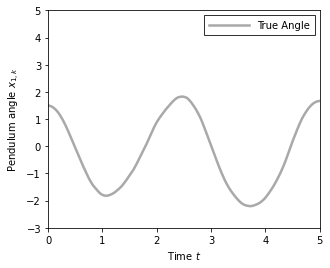

In [24]:
# Plot the generated data
plt.figure()
plt.plot(time_grid, states[:,0], color='darkgray', linewidth=2.5, label="True Angle")
# plt.plot(obs[:,0], obs[:,1], 'ok', fillstyle='none', ms=4, label='Measurements')
# plt.plot(m_kf[:,0], m_kf[:,1], color='k', linewidth=1.5, label="Filter Estimate")
plt.xlabel('Time $t$'); plt.ylabel('Pendulum angle $x_{1,k}$')
plt.xlim(0, 5); plt.ylim(-3, 5)
plt.yticks(jnp.arange(-3, 5.1, 1))
plt.gca().set_aspect(0.5)
plt.legend(loc=1, borderpad=0.5, handlelength=4, fancybox=False, edgecolor='k');
plt.show()